<a href="https://colab.research.google.com/github/rakshitgupta22/speech-emotion-recognition/blob/main/SpeechEmotionRecognitionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <font size="5">CS271 Team Project - Speech Emotion Recognition</font><br>
  <font size="3">Rakshit Gupta, Ayush Nair, Nikunj Rana</font><br>

In [ ]:
# Download dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
base_path = "/content/drive/MyDrive/CS271Project/"
%cd $base_path

/content/drive/MyDrive/CS271Project


In [ ]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preprocessing

In [ ]:
def show_emotion_waveplot(file_path: str):
    visited = list()
    files = []
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), sharey=True)
    for f in glob.glob(file_path):
        file_name = os.path.basename(f)
        attrs = file_name.split("-")
        if attrs[2] in visited:
            continue
        visited.append(attrs[2])
        files.append(f)
    for i, ax in enumerate(axes.flat):
        if i < len(files):
            audio_path = files[i]
            y, sr = librosa.load(audio_path)
            librosa.display.waveshow(y, sr=sr, ax=ax)
            ax.set_title(f'{emotions[visited[i]].upper()}')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')

    # Add a title to the entire plot
    fig.suptitle(f"{file_path.split('/')[1]}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to leave space for the suptitle
    plt.show()

# show_emotion_waveplot("./Actor_01/*.wav")

In [ ]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

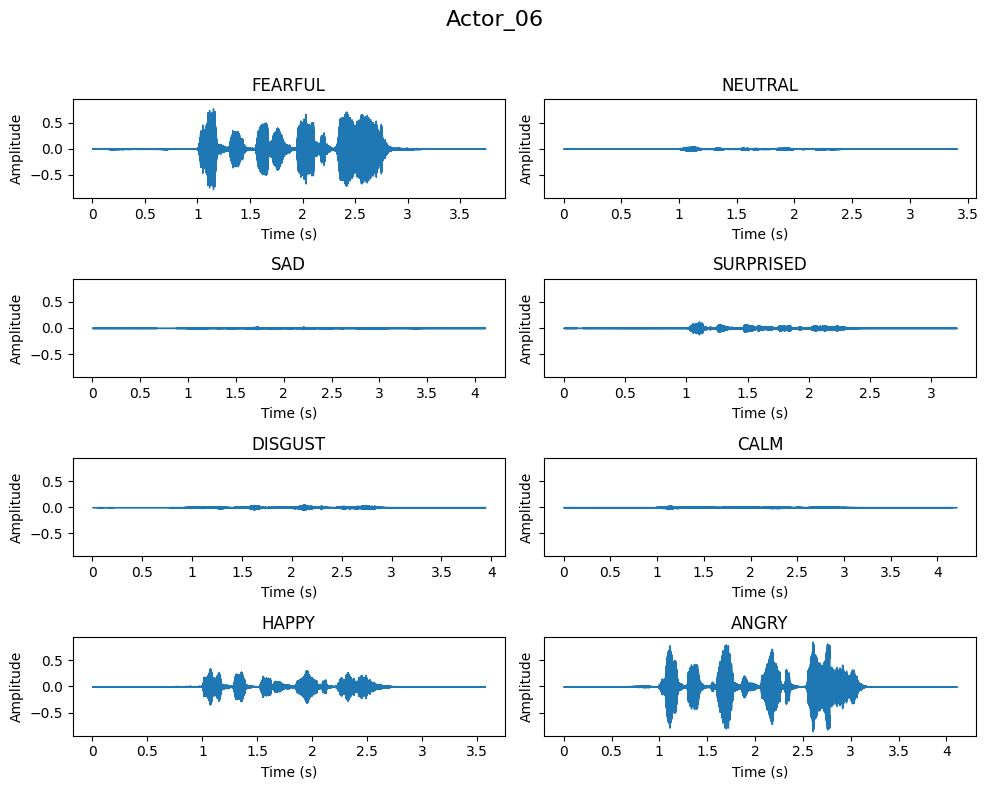

In [ ]:
show_emotion_waveplot("./Actor_06/*.wav")

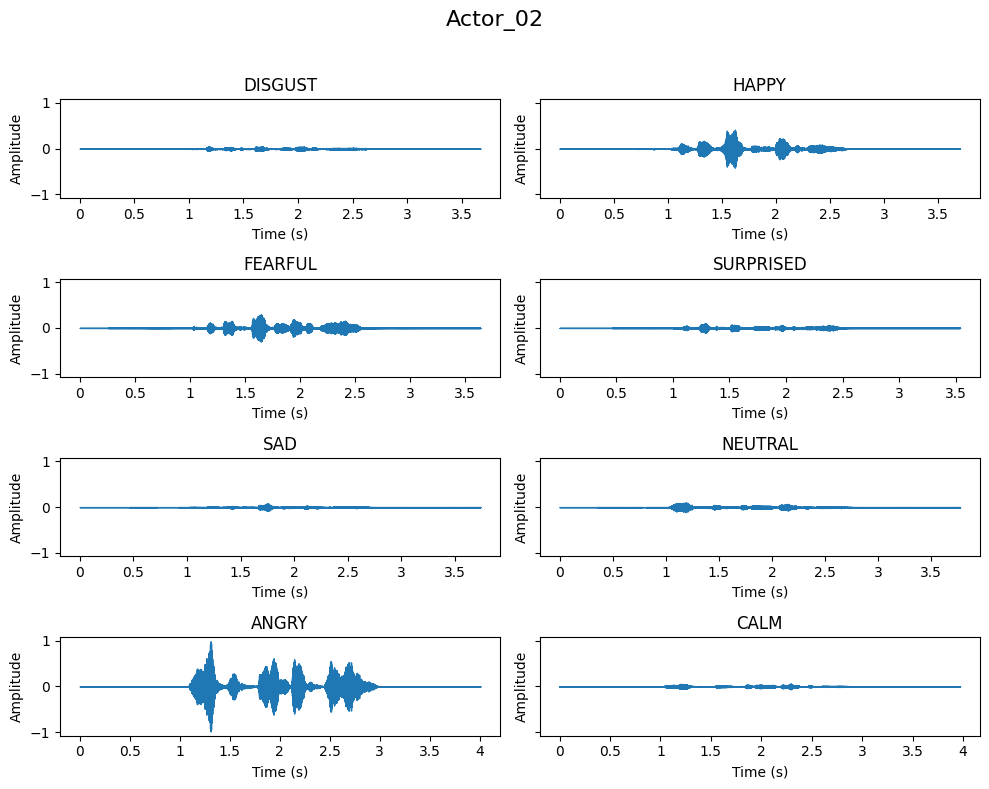

In [ ]:
show_emotion_waveplot("./Actor_02/*.wav")

In [ ]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc=True, chroma=True, mel=True, rms=True, zero_crossing_rate=True, spectral_centroid=True, spectral_bandwidth=True, spectral_contrast=True, spectral_rolloff=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        # print(sample_rate)
        stft = np.abs(librosa.stft(X))
        counter=0
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))

        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))

        if rms:
            rms_value = np.mean(librosa.feature.rms(y=X).T, axis=0)
            result = np.hstack((result, rms_value))

        if zero_crossing_rate:
            zero_crossing_rate_value = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
            result = np.hstack((result, zero_crossing_rate_value))

        if spectral_centroid:
            centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, centroid))

        if spectral_bandwidth:
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, bandwidth))

        if spectral_contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))

        if spectral_rolloff:
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, rolloff))

    return result

In [ ]:
# Load the data and extract features for each sound file
file_names, vocal_channels, emo, emo_intesity, repetitions, actor_sex  = [], [], [], [], [], []
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("./Actor_*/*.wav"):
        file_name=os.path.basename(file)
        attributes = file_name.split("-")
        file_names.append(file_name)
        vocal_channels.append(attributes[1])
        emotion=emotions[attributes[2]]
        emo.append(emotion)
        emo_intesity.append(attributes[3])
        repetitions.append(attributes[5])
        actor_sex.append("Female" if int(attributes[6].split(".")[0])%2==0 else "Male")
        # if emotion not in observed_emotions:
        #     continue
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
# Get the shape of the training and testing datasets
print(f"Total Files: {x_train.shape[0] + x_test.shape[0]}, Train: {x_train.shape[0]}, Test: {x_test.shape[0]}")

Total Files: 1440, Train: 1080, Test: 360


In [ ]:
x_train.shape

(1080, 165)

In [ ]:
# scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Classical Machine Learning Models

## Logistic Regression

In [ ]:
model = LogisticRegression(random_state=42, solver='lbfgs', n_jobs=-1)
model.fit(x_train_scaled,y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [ ]:
# Predict using the logistic regression model with selected features
y_pred = model.predict(x_test_scaled)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 53.06%


## MLP

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=64, epsilon=1e-08, hidden_layer_sizes=(450,),
                    learning_rate='adaptive', max_iter=500)
model.fit(x_train_scaled,y_train)

MLPClassifier(alpha=0.01, batch_size=64, hidden_layer_sizes=(450,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
# Predict using the logistic regression model with selected features
y_pred = model.predict(x_test_scaled)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 61.67%


              precision    recall  f1-score   support

     neutral       0.57      0.50      0.53        26
        calm       0.69      0.64      0.67        45
       happy       0.55      0.69      0.61        49
         sad       0.51      0.54      0.52        41
       angry       0.69      0.67      0.68        49
     fearful       0.65      0.44      0.52        55
     disgust       0.59      0.71      0.64        41
   surprised       0.68      0.70      0.69        54

    accuracy                           0.62       360
   macro avg       0.62      0.61      0.61       360
weighted avg       0.62      0.62      0.61       360



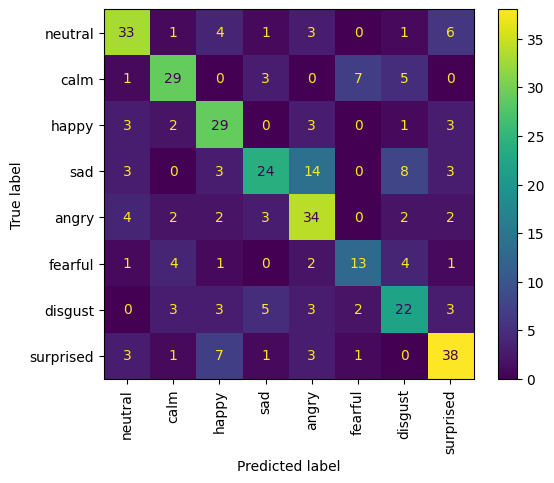

In [ ]:
print(classification_report(y_test, y_pred, labels=list(emotions.values())))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(x_train_scaled)
X_test = pca.transform(x_test_scaled)

In [ ]:
X_train_pca.shape

(1080, 20)

### Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=3, min_samples_split=3, criterion='entropy', n_jobs=-1, random_state=42)
model.fit(X_train_pca, y_train)

# Predict for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train_pca)

print("Training Accuracy: {:.2f}%".format(accuracy_score(y_true=y_train, y_pred=y_train_pred)*100))
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

Training Accuracy: 98.61%
Testing Accuracy: 45.28%


              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        26
        calm       0.51      0.82      0.63        45
       happy       0.42      0.45      0.44        49
         sad       0.38      0.34      0.36        41
       angry       0.54      0.51      0.53        49
     fearful       0.61      0.35      0.44        55
     disgust       0.29      0.37      0.32        41
   surprised       0.47      0.57      0.52        54

    accuracy                           0.45       360
   macro avg       0.40      0.43      0.40       360
weighted avg       0.43      0.45      0.43       360



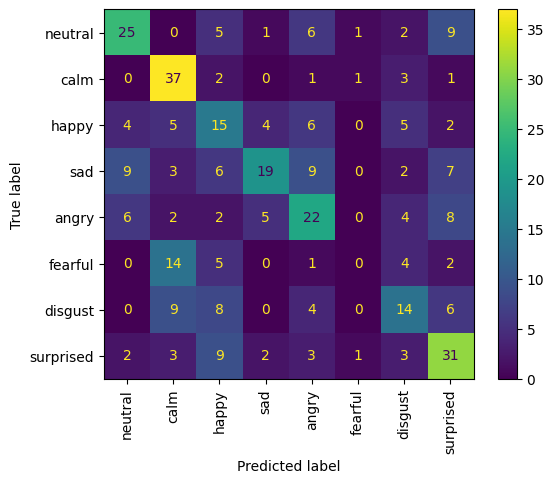

In [ ]:
print(classification_report(y_test, y_pred, labels=list(emotions.values())))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

### Bagging using SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

# PCA
model = BaggingClassifier(estimator=SVC(), n_estimators = 20)
model.fit(X_train_pca, y_train)

# Predict for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train_pca)

print("Training Accuracy: {:.2f}%".format(accuracy_score(y_true=y_train, y_pred=y_train_pred)*100))
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

Training Accuracy: 40.56%
Testing Accuracy: 35.83%


              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        26
        calm       0.33      0.73      0.46        45
       happy       0.35      0.35      0.35        49
         sad       0.23      0.20      0.21        41
       angry       0.70      0.43      0.53        49
     fearful       0.79      0.20      0.32        55
     disgust       0.18      0.44      0.26        41
   surprised       0.58      0.39      0.47        54

    accuracy                           0.36       360
   macro avg       0.40      0.34      0.32       360
weighted avg       0.44      0.36      0.35       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


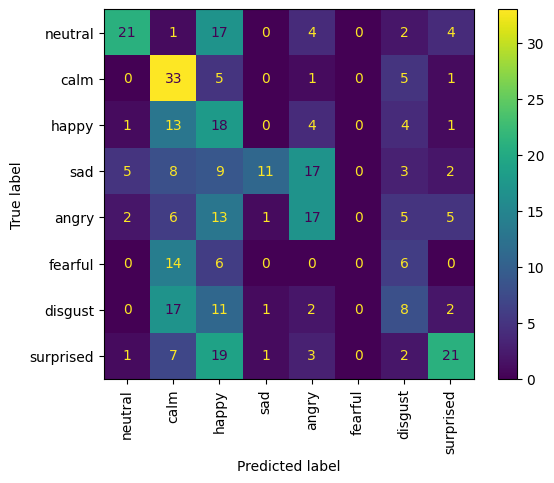

In [ ]:
print(classification_report(y_test, y_pred, labels=list(emotions.values())))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Boruta Feature Selection

In [ ]:
# Install and Import Boruta Library
!pip install boruta
from boruta import BorutaPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
x_train_scaled.shape

(1080, 165)

In [ ]:
###initialize Boruta
forest = RandomForestClassifier(n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(x_train_scaled, y_train)

BorutaPy(estimator=RandomForestClassifier(n_estimators=147, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7BB49F193840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7BB49F193840)

In [ ]:
x_train_scaled[:,np.logical_or(boruta.support_, boruta.support_weak_)].shape

(1080, 87)

In [ ]:
x_train_selected_boruta = x_train_scaled[:,np.logical_or(boruta.support_, boruta.support_weak_)]
X_test_selected_boruta = x_test_scaled[:,np.logical_or(boruta.support_, boruta.support_weak_)]

### Bagging SVC

In [ ]:
model = BaggingClassifier(estimator=SVC(), n_estimators = 20)
model.fit(x_train_selected_boruta, y_train)

# Predict for the test set
y_pred = model.predict(X_test_selected_boruta)
y_train_pred = model.predict(x_train_selected_boruta)

print("Training Accuracy: {:.2f}%".format(accuracy_score(y_true=y_train, y_pred=y_train_pred)*100))
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

Training Accuracy: 57.22%
Testing Accuracy: 48.33%


### Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=3, min_samples_split=3, criterion='entropy', n_jobs=-1, random_state=42)
model.fit(x_train_selected_boruta, y_train)

# Predict for the test set
y_pred = model.predict(X_test_selected_boruta)
y_train_pred = model.predict(x_train_selected_boruta)

print("Training Accuracy: {:.2f}%".format(accuracy_score(y_true=y_train, y_pred=y_train_pred)*100))
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

Training Accuracy: 99.54%
Testing Accuracy: 54.17%


              precision    recall  f1-score   support

     neutral       0.78      0.27      0.40        26
        calm       0.59      0.91      0.72        45
       happy       0.49      0.53      0.51        49
         sad       0.41      0.44      0.42        41
       angry       0.76      0.57      0.65        49
     fearful       0.64      0.45      0.53        55
     disgust       0.31      0.39      0.34        41
   surprised       0.60      0.63      0.61        54

    accuracy                           0.54       360
   macro avg       0.57      0.52      0.52       360
weighted avg       0.57      0.54      0.54       360



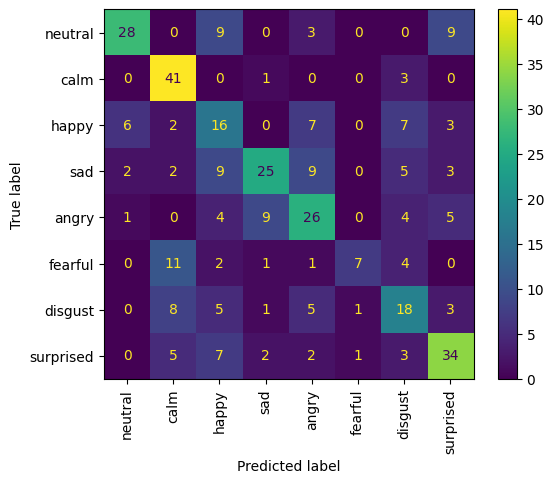

In [ ]:
print(classification_report(y_test, y_pred, labels=list(emotions.values())))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Feature Selection Using ANOVA

In [ ]:
k_best_features = 100
selector = SelectKBest(k=k_best_features)

# Fit the selector to the training data and transform the features
x_train_selected_anova = selector.fit_transform(x_train_scaled, y_train)
X_test_selected_anova = selector.transform(x_test_scaled)

### Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=40, criterion='entropy', n_jobs=-1, random_state=42)
model.fit(x_train_selected_anova, y_train)

# Predict using the logistic regression model with selected features
y_pred = model.predict(X_test_selected_anova)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with {k_best_features} selected features: {accuracy * 100:.2f}%')

Accuracy with 100 selected features: 55.83%


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_filter = RandomForestClassifier()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 5],
    'criterion': ['gini', 'entropy']
}
rf_gdcv_filter = GridSearchCV(rf_filter, tune_paragm, n_jobs=-1, cv=5, scoring='f1_macro')
rf_gdcv_filter.fit(x_train_selected_anova, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50, 100],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='f1_macro')

In [ ]:
rf_gdcv_filter.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

In [ ]:
# Train with Best Params
model = RandomForestClassifier(n_estimators=150, max_depth=100, min_samples_leaf=2, min_samples_split=5, criterion='entropy', n_jobs=-1, random_state=42)
model.fit(x_train_selected_anova, y_train)

# Predict using the logistic regression model with selected features
y_pred = model.predict(X_test_selected_anova)

              precision    recall  f1-score   support

     neutral       0.65      0.42      0.51        26
        calm       0.58      0.82      0.68        45
       happy       0.53      0.49      0.51        49
         sad       0.37      0.46      0.41        41
       angry       0.71      0.55      0.62        49
     fearful       0.69      0.49      0.57        55
     disgust       0.35      0.44      0.39        41
   surprised       0.52      0.52      0.52        54

    accuracy                           0.53       360
   macro avg       0.55      0.52      0.53       360
weighted avg       0.55      0.53      0.53       360



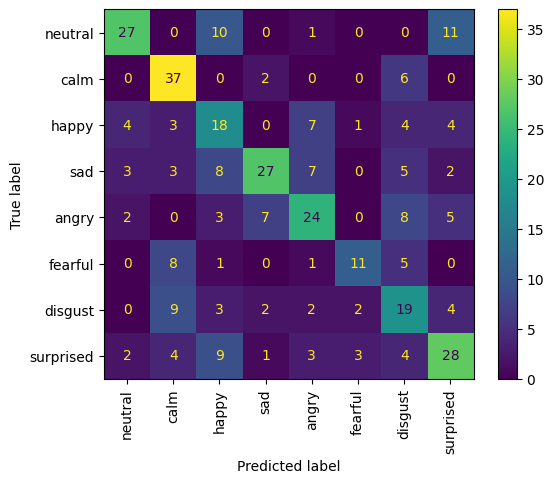

In [ ]:
print(classification_report(y_test, y_pred, labels=list(emotions.values())))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Implementing [Bagged support vector machines for emotion recognition from speech](https://www.sciencedirect.com/science/article/pii/S0950705119303533?casa_token=FGaqQ4VbD2EAAAAA:2t-2j0xgAcoUsrx_MOGVTP7ICPXu_B3vlSC0pcS3SmaGyYWLYTKJKuAkVBLH7TH3cF_QVTjYeA)

### Feature Engineering

In [ ]:
from scipy.stats import skew, kurtosis, iqr

# Overwriting the previous feature extraction function to meet requirements of the paper
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X, n_fft=512))
        counter=0
        result = np.array([])

        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
        delta = librosa.feature.delta(mfccs)
        delta_delta = librosa.feature.delta(mfccs, order=2)
        # Compute the mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=26)

        # Calculate the spectral centroids
        centroids = librosa.feature.spectral_centroid(S=mel_spectrogram)

        # Calculate additional statistics for MFCCs
        mean_mfccs = np.mean(mfccs.T, axis=0)
        var_mfccs = np.var(mfccs.T, axis=0)
        max_mfccs = np.max(mfccs.T, axis=0)
        min_mfccs = np.min(mfccs.T, axis=0)
        skew_mfccs = skew(mfccs.T, axis=0)
        kurtosis_mfccs = kurtosis(mfccs.T, axis=0)
        iqr_mfccs = iqr(mfccs.T, axis=0)

        result_mfcc = np.hstack((mean_mfccs, var_mfccs, max_mfccs, min_mfccs, skew_mfccs, kurtosis_mfccs, iqr_mfccs))

        # Calculate additional statistics for Delta
        mean_delta = np.mean(delta.T, axis=0)
        var_delta = np.var(delta.T, axis=0)
        max_delta = np.max(delta.T, axis=0)
        min_delta = np.min(delta.T, axis=0)
        skew_delta = skew(delta.T, axis=0)
        kurtosis_delta = kurtosis(delta.T, axis=0)
        iqr_delta = iqr(delta.T, axis=0)

        result_delta = np.hstack((mean_delta, var_delta, max_delta, min_delta, skew_delta, kurtosis_delta, iqr_delta))

        # Calculate additional statistics for Delta Delta
        mean_delta_delta = np.mean(delta_delta.T, axis=0)
        var_delta_delta = np.var(delta_delta.T, axis=0)
        max_delta_delta = np.max(delta_delta.T, axis=0)
        min_delta_delta = np.min(delta_delta.T, axis=0)
        skew_delta_delta = skew(delta_delta.T, axis=0)
        kurtosis_delta_delta = kurtosis(delta_delta.T, axis=0)
        iqr_delta_delta = iqr(delta_delta.T, axis=0)

        result_delta_delta = np.hstack((mean_delta_delta, var_delta_delta, max_delta_delta, min_delta_delta, skew_delta_delta, kurtosis_delta_delta, iqr_delta_delta))

        # Calculate additional statistics for Spectral Centroids
        centroids_mean = np.mean(mel_spectrogram, axis=1)
        centroids_var = np.var(mel_spectrogram, axis=1)
        centroids_max = np.max(mel_spectrogram, axis=1)
        centroids_min = np.min(mel_spectrogram, axis=1)
        centroids_skew = skew(mel_spectrogram, axis=1)
        centroids_kurtosis = kurtosis(mel_spectrogram, axis=1)
        centroids_iqr = iqr(mel_spectrogram, axis=1)

        result_spectral_centroids = np.hstack((centroids_mean,centroids_var,centroids_max,centroids_min,centroids_skew,centroids_kurtosis,centroids_iqr))

        # Concatenate all aggregated features
        result = np.hstack((result,result_mfcc, result_delta, result_delta_delta, result_spectral_centroids))

    return result


In [ ]:
x_train_svc, x_test_svc, y_train_svc, y_test_svc = load_data(test_size=0.25)

In [ ]:
# Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()

# Fit and transform the features
x_train_svc = scaler.fit_transform(x_train_svc)
x_test_svc = scaler.transform(x_test_svc)

In [ ]:
print(x_train_svc.shape)

(1080, 455)


### Data Balancing using SMOTE-TOMEK Links

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks


smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x_train_svc, y_train_svc = smote_tomek.fit_resample(x_train_svc, y_train_svc)

In [ ]:
print(x_train_svc.shape)

(1229, 455)


In [ ]:
import pandas as pd

y_train_series = pd.Series(y_train_svc)

# Get the distribution of classes
class_distribution = y_train_series.value_counts()

# Print the distribution
print("Class Distribution in y_train:")
print(class_distribution)

Class Distribution in y_train:
fearful      154
sad          154
happy        154
calm         154
disgust      154
neutral      154
surprised    154
angry        151
dtype: int64


### Feature Selection Using Boruta

In [ ]:
forest = RandomForestClassifier(n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(x_train_svc, y_train_svc)

BorutaPy(estimator=RandomForestClassifier(n_estimators=267, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7BB49F193840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7BB49F193840)

In [ ]:
print(x_train_svc[:,boruta.support_].shape)
x_train_svc[:,np.logical_or(boruta.support_, boruta.support_weak_)].shape

(1229, 288)


(1229, 319)

In [ ]:
x_train_selected = x_train_svc[:,boruta.support_]
X_test_selected = x_test_svc[:,boruta.support_]

### Model Training - Bagging SVC

In [ ]:
model = BaggingClassifier(estimator=SVC(), n_estimators=20)
model.fit(x_train_selected, y_train_svc)

BaggingClassifier(estimator=SVC(), n_estimators=20)

In [ ]:
# Predict for the test set
y_pred = model.predict(X_test_selected)
y_train_pred = model.predict(x_train_selected)


Train Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.80      0.87       151
        calm       0.70      0.88      0.78       154
     disgust       0.73      0.85      0.78       154
     fearful       0.80      0.82      0.81       154
       happy       0.83      0.67      0.74       154
     neutral       0.68      0.94      0.79       154
         sad       0.72      0.40      0.52       154
   surprised       0.78      0.75      0.77       154

    accuracy                           0.76      1229
   macro avg       0.78      0.76      0.76      1229
weighted avg       0.77      0.76      0.76      1229



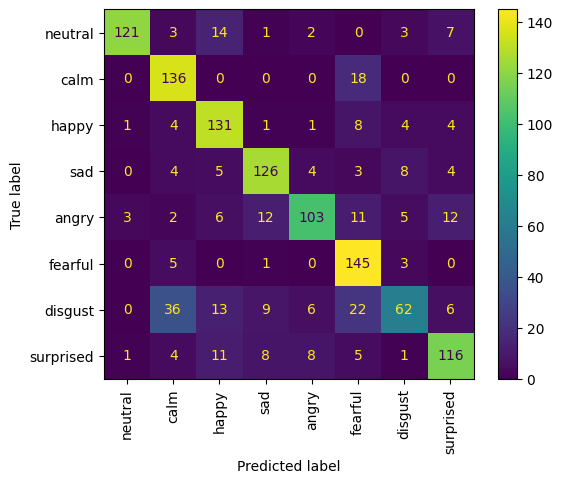

In [ ]:
print("\nTrain Classification Report:")
print(classification_report(y_train_svc, y_train_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train_svc, y_train_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')


Test Classification Report:
              precision    recall  f1-score   support

       angry       0.86      0.67      0.75        54
        calm       0.60      0.72      0.66        54
     disgust       0.57      0.71      0.64        38
     fearful       0.69      0.69      0.69        52
       happy       0.71      0.64      0.67        47
     neutral       0.34      0.74      0.47        19
         sad       0.61      0.27      0.37        52
   surprised       0.69      0.76      0.72        45

    accuracy                           0.64       361
   macro avg       0.64      0.65      0.62       361
weighted avg       0.66      0.64      0.63       361



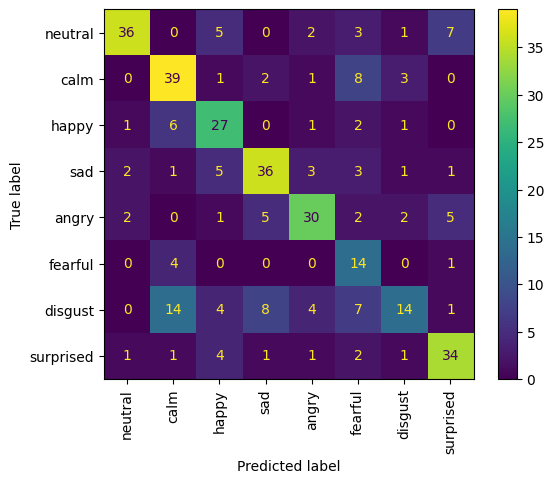

In [ ]:
print("\nTest Classification Report:")
print(classification_report(y_test_svc, y_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_svc, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

# Deep Learning

## Spectrogram to CNN to Linear Classifier

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from joblib import delayed, Parallel

In [ ]:
def process_audio_file(input_file, output_file, target_duration=5.1):
    # Load the audio file
    y, sr = librosa.load(input_file, sr=None)

    # Get the current duration of the audio
    current_duration = librosa.get_duration(y=y, sr=sr)

    if current_duration < target_duration:
        # Pad the audio with silence to the target duration
        pad_duration = target_duration - current_duration
        silence = np.zeros(int(pad_duration * sr))
        y_padded = np.concatenate((y, silence))
    elif current_duration > target_duration:
        # Crop the audio to the target duration
        y_padded = y[:int(target_duration * sr)]
    else:
        # The duration is already equal to the target duration
        y_padded = y

    # Save the processed audio to a new file
    soundfile.write(output_file, y_padded, sr)

files = glob.glob("./Actor_*/*.wav")
output_dir = os.path.join(os.path.dirname(os.getcwd()), "padded-audio-data")
os.makedirs(output_dir, exist_ok=True)
for file in files:
    file_name = os.path.basename(file)
    actor_folder = os.path.basename(os.path.dirname(file))
    output_folder = os.path.join(output_dir, actor_folder)
    os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist
    output_file = os.path.join(output_folder, file_name)
    process_audio_file(file, output_file, target_duration=5.3)

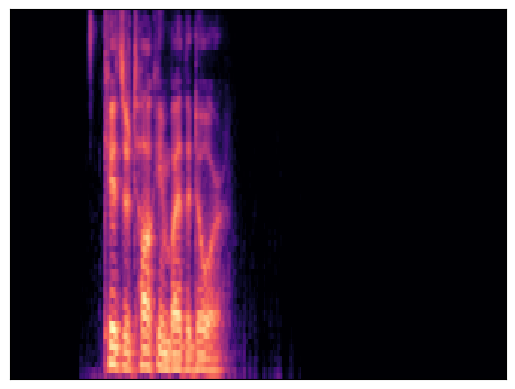

In [ ]:
y, sr = librosa.load("../padded-audio-data/Actor_01/03-01-01-01-01-01-01.wav", sr=None)
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=1024, hop_length=None)
spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(spec_db, sr=sr)

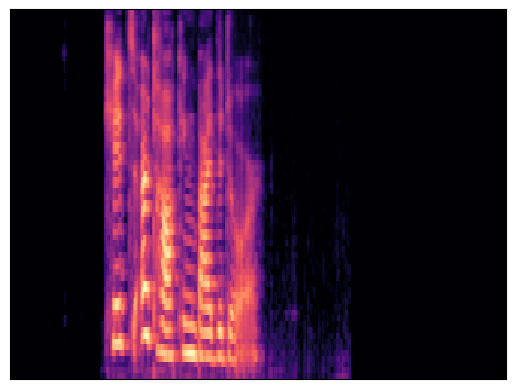

In [ ]:
y, sr = librosa.load("../padded-audio-data/Actor_02/03-01-01-01-01-01-02.wav", sr=None)
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=1024, hop_length=None)
spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(spec_db, sr=sr)

In [ ]:
def extract_mel_spectrogram(file_name, n_mels=128, n_fft=2048, hop_length=None):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        stft = np.abs(librosa.stft(X))
        rms_value = librosa.feature.rms(y=X)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=X)
        spectral_centroid = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=X, sr=sample_rate)
        spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=X, sr=sample_rate)
        combined_features = np.concatenate([
            mel_spectrogram,
            rms_value,
            mfccs,
            chroma,
            zero_crossing_rate,
            spectral_centroid,
            spectral_bandwidth,
            spectral_contrast,
            spectral_rolloff
        ], axis=0)


    return combined_features

def load_padded_parallel(test_size=0.25, n_jobs=-1):
    def process_file(file):
        file_name = os.path.basename(file)
        attributes = file_name.split("-")
        emotion = emotions[attributes[2]]
        feature = extract_mel_spectrogram(file)
        return feature, int(attributes[2])-1

    files = glob.glob(os.path.join(os.path.dirname(os.getcwd()), "padded-audio-data", "Actor_*", "*.wav"))
    results = Parallel(n_jobs=n_jobs)(delayed(process_file)(file) for file in files)
    x, y = zip(*results)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
extract_mel_spectrogram("../padded-audio-data/Actor_01/03-01-01-01-01-01-01.wav")

array([[ -80.        ,  -80.        ,  -80.        , ...,  -80.        ,
         -80.        ,  -80.        ],
       [ -80.        ,  -80.        ,  -80.        , ...,  -80.        ,
         -80.        ,  -80.        ],
       [ -80.        ,  -80.        ,  -80.        , ...,  -80.        ,
         -80.        ,  -80.        ],
       ...,
       [  13.91452913,   13.91452913,   14.45040716, ...,   13.91452913,
          13.91452913,   13.91452913],
       [  13.91452913,   13.91452913,   14.50332429, ...,   13.91452913,
          13.91452913,   13.91452913],
       [   0.        ,    0.        , 6671.875     , ...,    0.        ,
           0.        ,    0.        ]])

In [ ]:
x_train, x_test, y_train, y_test = load_padded_parallel()

In [ ]:
# Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
# X_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [ ]:
x_train.shape

(1080, 165, 166)

In [ ]:
x_test.shape

(361, 165, 166)

In [ ]:
# Build the CNN model
def build_emotion_classifier_model(input_shape=(64, 332, 1), num_classes=8):
    model = Sequential()

    # Convolutional Block 1
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output for dense layers
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for multi-class classification

    return model

# Create the emotion classifier model
emotion_classifier_model = build_emotion_classifier_model(input_shape=(165, 166, 1), num_classes=8)

# Display the model summary
emotion_classifier_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 165, 166, 1)       4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 163, 164, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 81, 82, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 79, 80, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 40, 64)        0         
 g2D)                                                            
                                                      

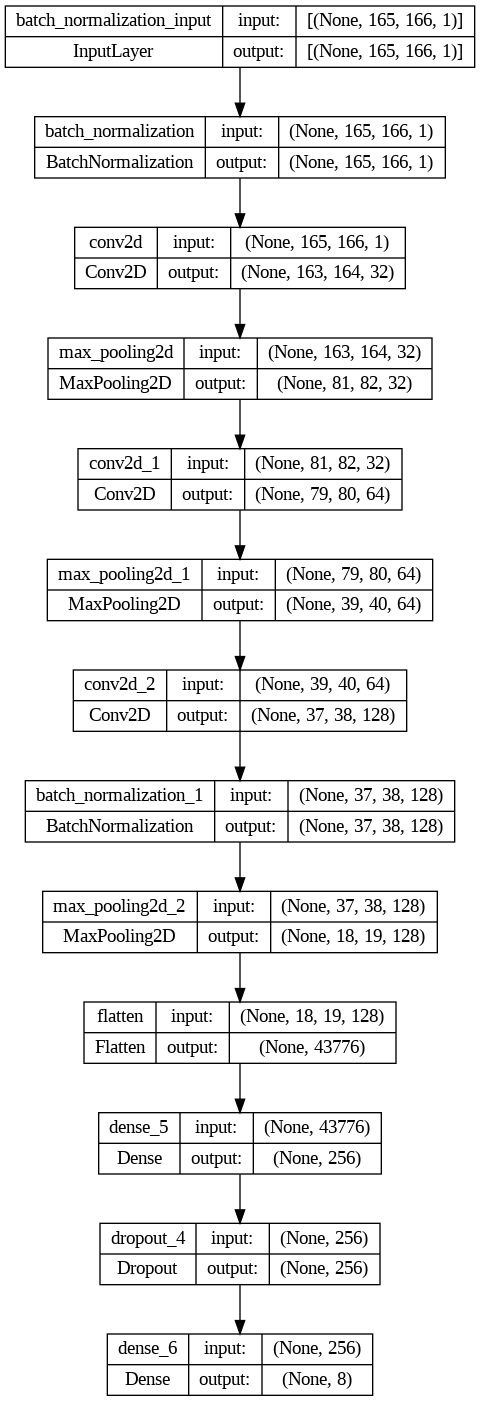

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(emotion_classifier_model, to_file="./CNN_model_arch1.png", show_shapes=True)

In [ ]:
y_train_onehot = to_categorical(y_train, num_classes=8)
y_test_onehot = to_categorical(y_test, num_classes=8)

In [ ]:
early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./cnn_model_checkpoint.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

# Compile the model
emotion_classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = emotion_classifier_model.fit(x_train, y_train_onehot, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

# Evaluate the model on the test set
loss, accuracy = emotion_classifier_model.evaluate(x_test, y_test_onehot)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/30
27/27 [==============================] - 5s 84ms/step - loss: 1.4693 - accuracy: 0.4120 - val_loss: 2.1023 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - 5s 185ms/step - loss: 1.3754 - accuracy: 0.4479 - val_loss: 1.9728 - val_accuracy: 0.1528 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - 2s 69ms/step - loss: 1.3112 - accuracy: 0.4861 - val_loss: 1.9287 - val_accuracy: 0.1713 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - 1s 52ms/step - loss: 1.2941 - accuracy: 0.4884 - val_loss: 1.7580 - val_accuracy: 0.3287 - lr: 0.0010
Epoch 5/30
27/27 [==============================] - 1s 33ms/step - loss: 1.2185 - accuracy: 0.5046 - val_loss: 3.0292 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 6/30
27/27 [==============================] - 1s 33ms/step - loss: 1.2246 - accuracy: 0.5012 - val_loss: 1.7740 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 7/30
27/27 [==============================] - 1s 33ms/step - loss: 1.

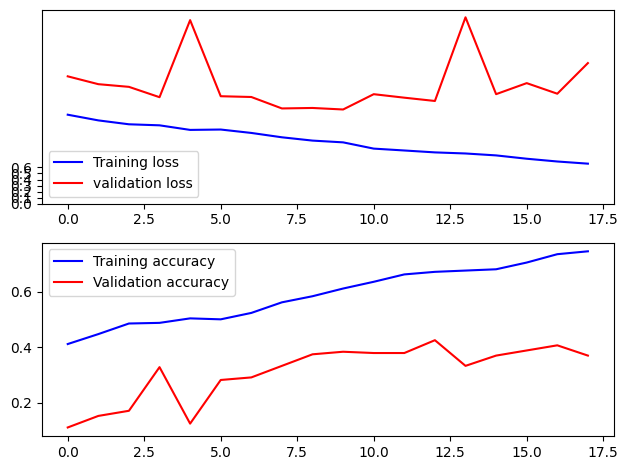

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

12/12 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.30      0.74      0.42        19
           1       0.54      0.63      0.58        54
           2       0.37      0.53      0.44        47
           3       0.43      0.23      0.30        52
           4       0.48      0.59      0.53        54
           5       0.59      0.25      0.35        52
           6       0.56      0.50      0.53        38
           7       0.65      0.49      0.56        45

    accuracy                           0.47       361
   macro avg       0.49      0.50      0.46       361
weighted avg       0.50      0.47      0.46       361



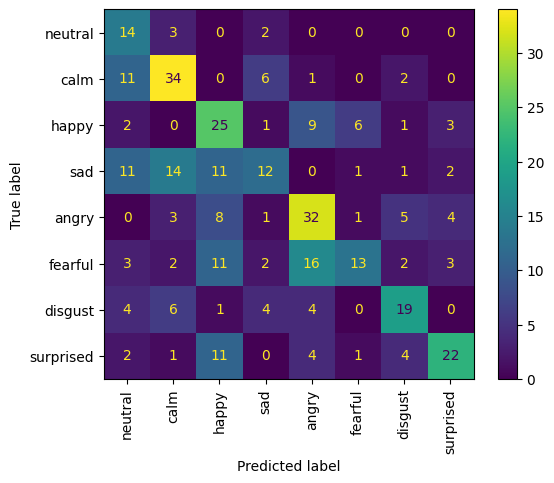

In [ ]:
y_pred = emotion_classifier_model.predict(x_test)
prediction_labels = np.argmax(y_pred, axis = 1)
# true_labels = np.argmax(y_test, axis = 1)

print(classification_report(y_test, prediction_labels))
ConfusionMatrixDisplay.from_predictions(y_test, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

34/34 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.43      0.83      0.56        77
           1       0.77      0.84      0.81       138
           2       0.46      0.75      0.57       146
           3       0.70      0.44      0.54       140
           4       0.74      0.79      0.76       138
           5       0.89      0.48      0.62       140
           6       0.88      0.76      0.82       154
           7       0.68      0.45      0.54       147

    accuracy                           0.66      1080
   macro avg       0.69      0.67      0.65      1080
weighted avg       0.71      0.66      0.66      1080



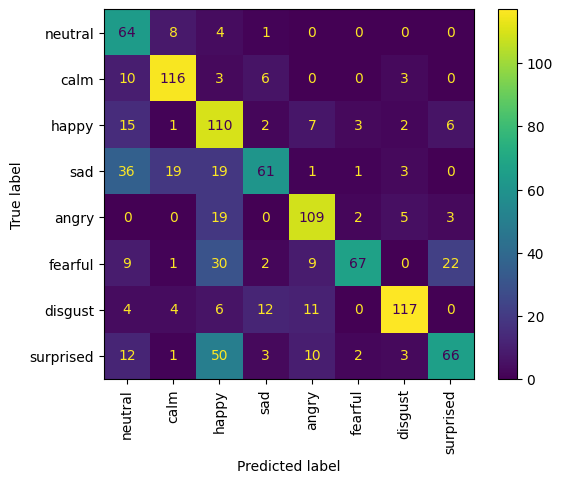

In [ ]:
y_pred_train = emotion_classifier_model.predict(x_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

# true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(y_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(y_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Creating Time-Series Data

In [ ]:
def get_emotion_label_from_filename(filename):
    return filename.split("-")[2]

In [ ]:
def process_audio_files(dataset_path):
    data = []
    labels = []
    max_len = 0

    # Iterate through all files in the specified directory
    for filename in glob.glob(dataset_path):
        emotion = get_emotion_label_from_filename(filename)  # Implement this function

        with soundfile.SoundFile(filename) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate
            stft = np.abs(librosa.stft(X))

            # Compute the Mel-frequency cepstral coefficients (MFCCs) from the audio signal
            mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)

            # Compute the chroma feature
            chroma = librosa.feature.chroma_stft(S=np.abs(librosa.stft(X)), sr=sample_rate)

            # Compute the mel spectrogram
            mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)

            rms_value = librosa.feature.rms(y=X)

            zero_crossing_rate_value = librosa.feature.zero_crossing_rate(y=X)

            centroid = librosa.feature.spectral_centroid(y=X, sr=sample_rate)

            bandwidth = librosa.feature.spectral_bandwidth(y=X, sr=sample_rate)

            contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)

            rolloff = librosa.feature.spectral_rolloff(y=X, sr=sample_rate)

            # Concatenate the features along the feature axis
            features = np.concatenate([mfccs, chroma, mel, rms_value,
                                       zero_crossing_rate_value, centroid,
                                       bandwidth, contrast, rolloff], axis=0)

            # Update the maximum sequence length
            max_len = max(max_len, features.shape[1])

            # Transpose the MFCC matrix to have time frames as the first dimension
            features = features.T

            data.append(features)
            labels.append(emotion)

    return np.array(data, dtype=object), np.array(labels), max_len

In [ ]:
X, Y, max_pad_len = process_audio_files("./Actor_*/*.wav")

Pad all the audio sequences with 0s at end so that each sequence is of same length

In [ ]:
X_padded = np.array([np.pad(seq, pad_width=((0, max_pad_len-seq.shape[0]), (0, 0)), mode='constant') for seq in X])
# ((0, max_pad_len-seq.shape[0]), (0, 0)) means 0 rows in begining, 0 at end and then 2nd tuple also same 0 cols in beg and end

In [ ]:
X_padded.shape

(1441, 165, 192)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = to_categorical(label_encoder.fit_transform(Y))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, encoded_labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Print the shape of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("max_pad_len:", max_pad_len)

X_train shape: (1152, 165, 192)
X_test shape: (289, 165, 192)
y_train shape: (1152, 8)
y_test shape: (289, 8)
max_pad_len: 165


## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')

callbacks_list = [early, learning_rate_reduction]
callbacks = callbacks_list

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 165, 100)          117200    
                                                                 
 lstm_4 (LSTM)               (None, 165, 100)          80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 150)               15150     
                                                                 
 dropout_6 (Dropout)         (None, 150)               0         
                                                                 
 dense_5 (Dense)             (None, 150)              

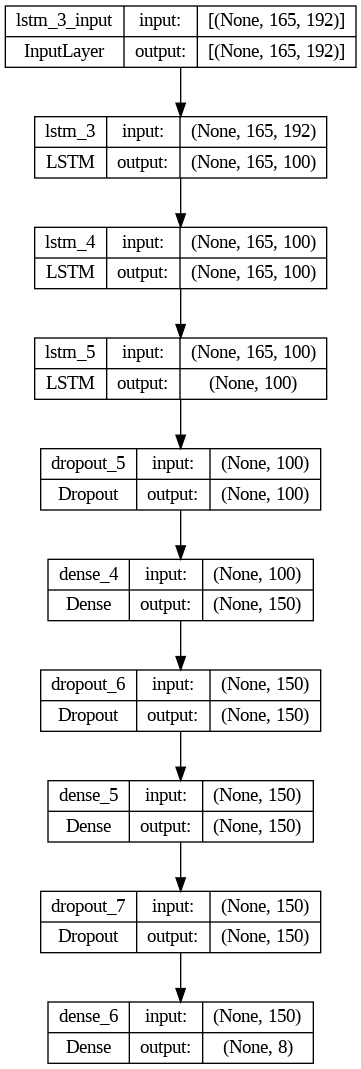

In [ ]:
plot_model(model, to_file="./LSTM_model_arch.png", show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 27s 673ms/step - loss: 2.0852 - accuracy: 0.1260 - val_loss: 2.0517 - val_accuracy: 0.1342 - lr: 0.0010
Epoch 2/30
29/29 [==============================] - 18s 631ms/step - loss: 2.0717 - accuracy: 0.1564 - val_loss: 2.0676 - val_accuracy: 0.1342 - lr: 0.0010
Epoch 3/30
29/29 [==============================] - 18s 618ms/step - loss: 2.0817 - accuracy: 0.1303 - val_loss: 2.0617 - val_accuracy: 0.1169 - lr: 0.0010
Epoch 4/30
29/29 [==============================] - 18s 613ms/step - loss: 2.0769 - accuracy: 0.1444 - val_loss: 2.0643 - val_accuracy: 0.1342 - lr: 0.0010
Epoch 5/30
29/29 [==============================] - 18s 614ms/step - loss: 2.0739 - accuracy: 0.1390 - val_loss: 2.0536 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 6/30
29/29 [==============================] - 18s 623ms/step - loss: 2.0639 - accuracy: 0.1455 - val_loss: 2.0376 - val_accuracy: 0.1602 - lr: 0.0010
Epoch 7/30
29/29 [==============================] - 18s 619ms/st

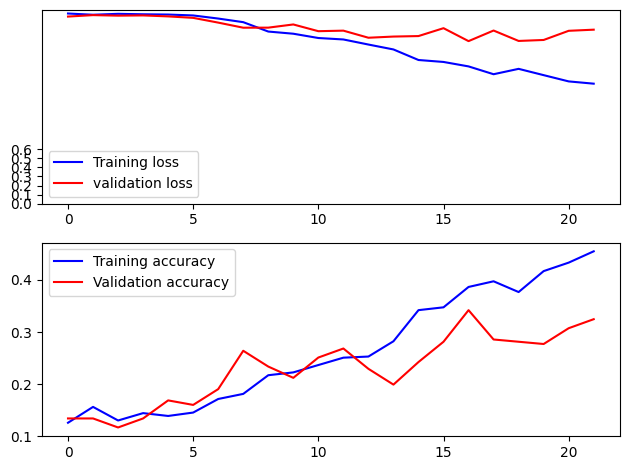

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

10/10 [==============================] - 6s 270ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.37      0.80      0.50        44
           2       0.32      0.23      0.27        44
           3       0.17      0.18      0.18        39
           4       0.54      0.63      0.58        30
           5       0.26      0.48      0.34        33
           6       0.80      0.11      0.19        37
           7       0.24      0.12      0.16        43

    accuracy                           0.33       289
   macro avg       0.34      0.32      0.28       289
weighted avg       0.35      0.33      0.29       289



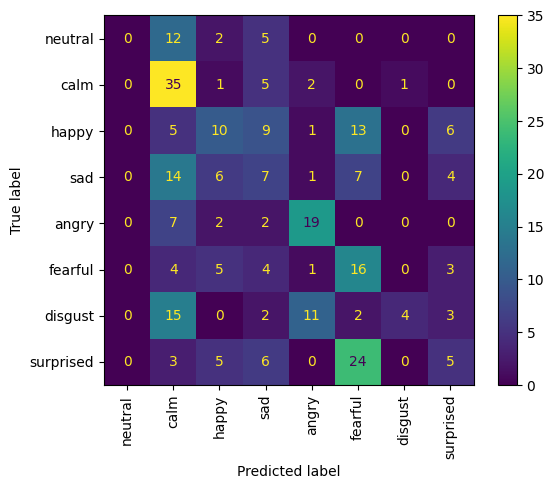

In [ ]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)
true_labels = np.argmax(y_test, axis = 1)

print(classification_report(true_labels, prediction_labels))
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

36/36 [==============================] - 6s 170ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.39      0.87      0.54       148
           2       0.36      0.25      0.29       149
           3       0.30      0.27      0.28       153
           4       0.60      0.75      0.67       162
           5       0.40      0.72      0.51       159
           6       0.50      0.05      0.08       155
           7       0.30      0.15      0.20       149

    accuracy                           0.41      1152
   macro avg       0.36      0.38      0.32      1152
weighted avg       0.38      0.41      0.35      1152



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


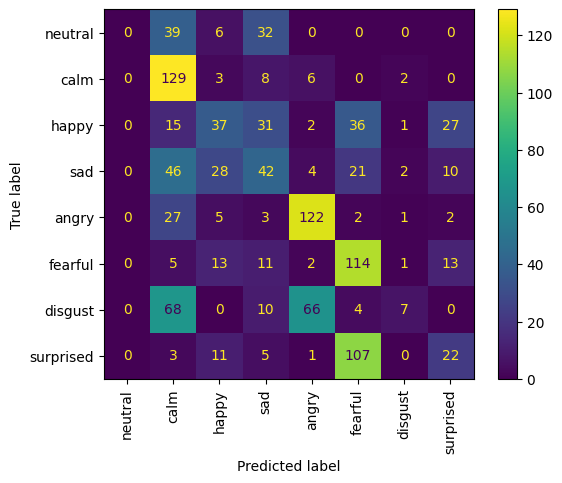

In [ ]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## CNN-LSTM

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Reshape

early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, min_delta=0.001, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./cnn_lstm_model_checkpoint1.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

# Create a Sequential model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(150))

model.add(Dropout(0.3))
# Dense layer for classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 163, 32)           18464     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 81, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 79, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 39, 64)            0         
 g1D)                                                            
                                                                 
 lstm_12 (LSTM)              (None, 39, 200)           212000    
                                                                 
 lstm_13 (LSTM)              (None, 150)              

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 17s 340ms/step - loss: 1.9652 - accuracy: 0.2139 - val_loss: 1.7757 - val_accuracy: 0.2641 - lr: 0.0010
Epoch 2/30
29/29 [==============================] - 7s 253ms/step - loss: 1.6902 - accuracy: 0.3529 - val_loss: 1.7018 - val_accuracy: 0.3506 - lr: 0.0010
Epoch 3/30
29/29 [==============================] - 8s 264ms/step - loss: 1.5464 - accuracy: 0.4028 - val_loss: 1.7190 - val_accuracy: 0.3377 - lr: 0.0010
Epoch 4/30
29/29 [==============================] - 9s 304ms/step - loss: 1.4475 - accuracy: 0.4441 - val_loss: 1.7016 - val_accuracy: 0.3593 - lr: 0.0010
Epoch 5/30
29/29 [==============================] - 7s 229ms/step - loss: 1.4114 - accuracy: 0.4625 - val_loss: 1.5436 - val_accuracy: 0.4459 - lr: 0.0010
Epoch 6/30
29/29 [==============================] - 11s 378ms/step - loss: 1.3047 - accuracy: 0.4940 - val_loss: 1.5874 - val_accuracy: 0.3983 - lr: 0.0010
Epoch 7/30
29/29 [==============================] - 6s 224ms/step - 

In [ ]:
model.load_weights("./cnn_lstm_model_checkpoint.ckpt")

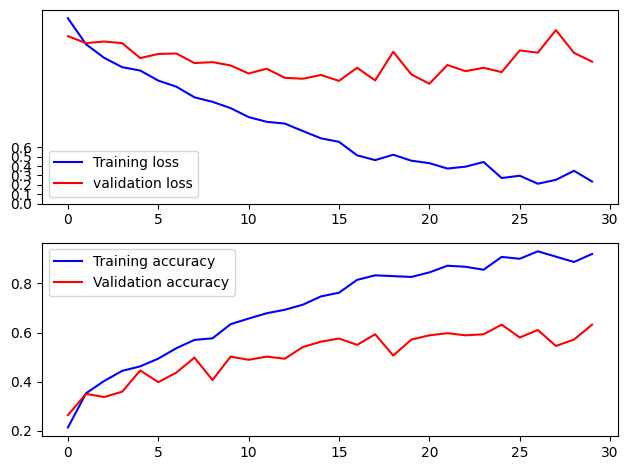

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)

10/10 [==============================] - 2s 68ms/step


In [ ]:
true_labels = np.argmax(y_test, axis = 1)

In [ ]:
print(classification_report(true_labels, prediction_labels))

              precision    recall  f1-score   support

           0       0.34      0.53      0.42        19
           1       0.87      0.59      0.70        44
           2       0.54      0.50      0.52        44
           3       0.65      0.72      0.68        39
           4       0.78      0.60      0.68        30
           5       0.48      0.42      0.45        33
           6       0.54      0.70      0.61        37
           7       0.85      0.91      0.88        43

    accuracy                           0.63       289
   macro avg       0.63      0.62      0.62       289
weighted avg       0.66      0.63      0.64       289



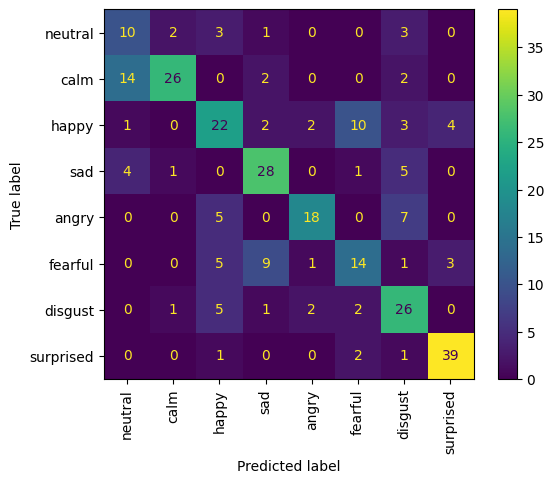

In [ ]:
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

36/36 [==============================] - 6s 164ms/step
              precision    recall  f1-score   support

           0       0.69      0.88      0.78        77
           1       0.95      0.83      0.88       148
           2       0.83      0.86      0.84       149
           3       0.85      0.84      0.85       153
           4       0.97      0.83      0.90       162
           5       0.89      0.87      0.88       159
           6       0.85      0.94      0.90       155
           7       0.94      0.95      0.95       149

    accuracy                           0.88      1152
   macro avg       0.87      0.88      0.87      1152
weighted avg       0.88      0.88      0.88      1152



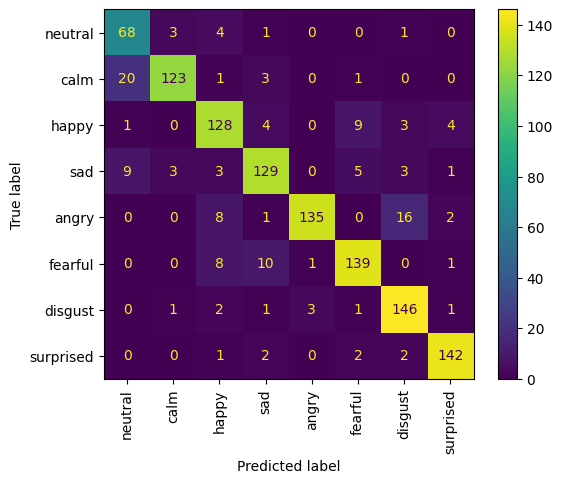

In [ ]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

### Modify Loss Function of CNN-LSTM to handle imbalance

In [ ]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
labels = np.argmax(y_train, axis=1)

array([5, 4, 5, ..., 4, 4, 4])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights

array([1.87012987, 0.97297297, 0.96644295, 0.94117647, 0.88888889,
       0.90566038, 0.92903226, 0.96644295])

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Reshape

early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, min_delta=0.001, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./cnn_lstm_model_modified_loss_function_checkpoint1.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

# Create a Sequential model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(150))

model.add(Dropout(0.3))
# Dense layer for classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 163, 32)           18464     
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 79, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 39, 64)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 39, 200)           212000    
                                                                 
 lstm_1 (LSTM)               (None, 150)               2

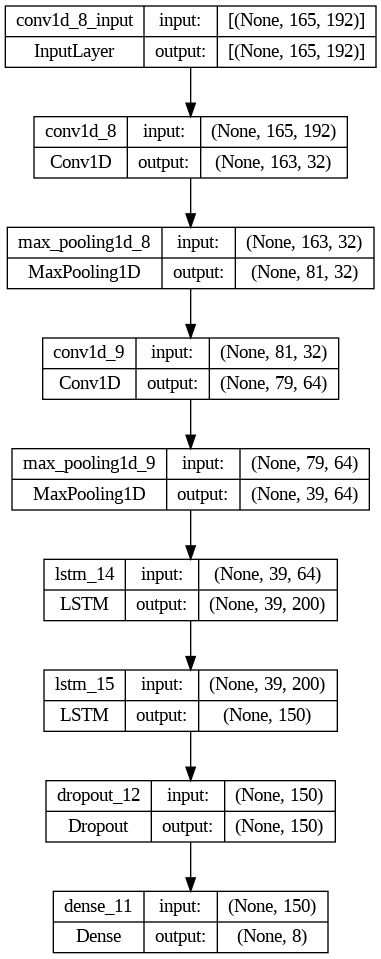

In [ ]:
plot_model(model, to_file="./CNN_LSTM_model_arch.png", show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks, class_weight=dict(enumerate(class_weights)))

Epoch 1/30
29/29 [==============================] - 20s 90ms/step - loss: 1.9847 - accuracy: 0.2215 - val_loss: 1.8141 - val_accuracy: 0.3117 - lr: 0.0010
Epoch 2/30
29/29 [==============================] - 1s 33ms/step - loss: 1.7296 - accuracy: 0.3398 - val_loss: 1.8064 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 3/30
29/29 [==============================] - 1s 19ms/step - loss: 1.6342 - accuracy: 0.3496 - val_loss: 1.6897 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 4/30
29/29 [==============================] - 0s 13ms/step - loss: 1.5671 - accuracy: 0.4017 - val_loss: 1.6481 - val_accuracy: 0.3593 - lr: 0.0010
Epoch 5/30
29/29 [==============================] - 0s 12ms/step - loss: 1.4849 - accuracy: 0.4300 - val_loss: 1.6331 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 6/30
29/29 [==============================] - 0s 13ms/step - loss: 1.4467 - accuracy: 0.4430 - val_loss: 1.7580 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 7/30
29/29 [==============================] - 0s 16ms/step - loss: 1.

In [ ]:
model.load_weights("./cnn_lstm_model_modified_loss_function_checkpoint1.ckpt")

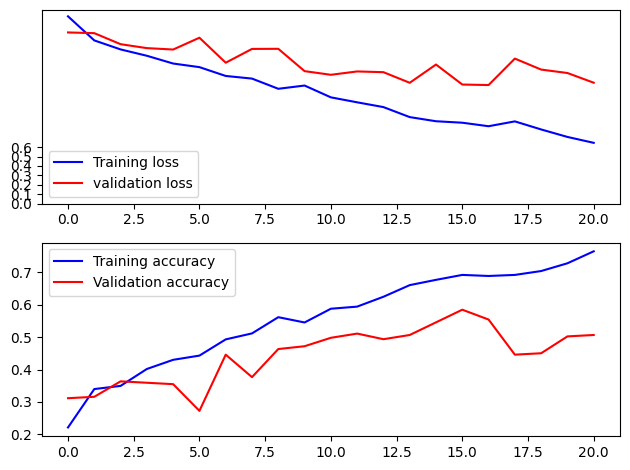

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
true_labels = np.argmax(y_test, axis = 1)

10/10 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.48      0.68      0.57        19
           1       0.76      0.80      0.78        44
           2       0.45      0.34      0.39        44
           3       0.67      0.46      0.55        39
           4       0.67      0.67      0.67        30
           5       0.49      0.52      0.50        33
           6       0.64      0.57      0.60        37
           7       0.62      0.84      0.71        43

    accuracy                           0.61       289
   macro avg       0.60      0.61      0.59       289
weighted avg       0.61      0.61      0.60       289



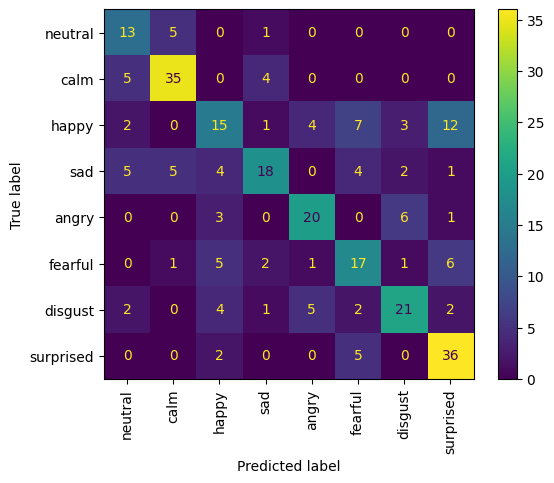

In [ ]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)

print(classification_report(true_labels, prediction_labels))
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

36/36 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.58      0.78      0.67        77
           1       0.77      0.82      0.79       148
           2       0.63      0.54      0.58       149
           3       0.59      0.45      0.51       153
           4       0.86      0.73      0.79       162
           5       0.77      0.79      0.78       159
           6       0.77      0.69      0.73       155
           7       0.66      0.91      0.76       149

    accuracy                           0.71      1152
   macro avg       0.70      0.71      0.70      1152
weighted avg       0.71      0.71      0.70      1152



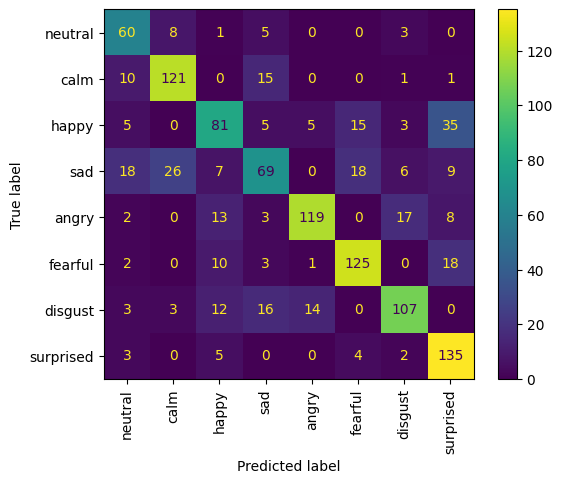

In [ ]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## biLSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional, InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 165, 200)          234400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 408       
                                                                 
Total params: 485658 (1.85 MB)
Trainable params: 48565

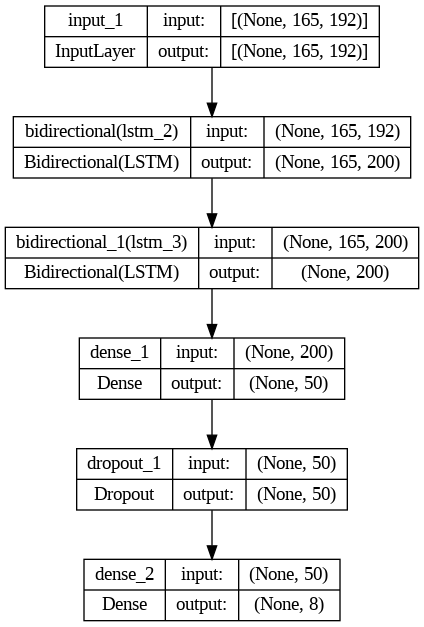

In [ ]:
plot_model(model, to_file="./BiLSTM_model_arch.png", show_shapes=True)

In [ ]:
early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, min_delta=0.001, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./bilstm_model_checkpoint.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 13s 121ms/step - loss: 2.0569 - accuracy: 0.1683 - val_loss: 2.0382 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 2/30
29/29 [==============================] - 1s 48ms/step - loss: 1.9381 - accuracy: 0.2410 - val_loss: 1.8855 - val_accuracy: 0.2554 - lr: 0.0010
Epoch 3/30
29/29 [==============================] - 1s 51ms/step - loss: 1.8627 - accuracy: 0.2573 - val_loss: 1.8560 - val_accuracy: 0.2900 - lr: 0.0010
Epoch 4/30
29/29 [==============================] - 1s 37ms/step - loss: 1.7863 - accuracy: 0.3029 - val_loss: 1.7745 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 5/30
29/29 [==============================] - 1s 33ms/step - loss: 1.7047 - accuracy: 0.3290 - val_loss: 1.7819 - val_accuracy: 0.2641 - lr: 0.0010
Epoch 6/30
29/29 [==============================] - 1s 37ms/step - loss: 1.6586 - accuracy: 0.3670 - val_loss: 1.7864 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 7/30
29/29 [==============================] - 1s 35ms/step - loss: 1

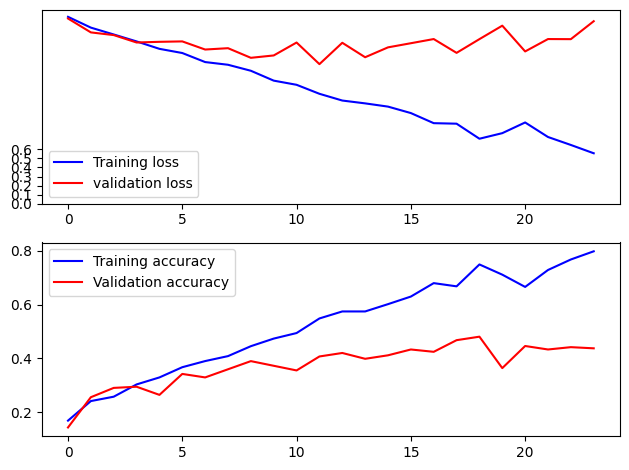

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

10/10 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       0.12      0.11      0.11        19
           1       0.58      0.66      0.62        44
           2       0.37      0.45      0.41        44
           3       0.40      0.51      0.45        39
           4       0.73      0.63      0.68        30
           5       0.46      0.39      0.43        33
           6       0.40      0.38      0.39        37
           7       0.57      0.40      0.47        43

    accuracy                           0.46       289
   macro avg       0.45      0.44      0.44       289
weighted avg       0.47      0.46      0.46       289



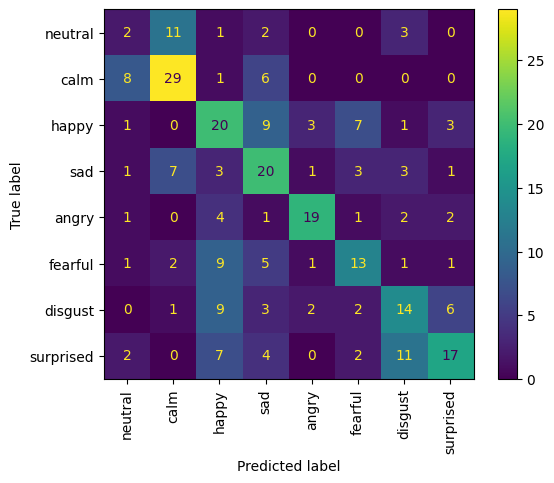

In [ ]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)

print(classification_report(true_labels, prediction_labels))
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

36/36 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        77
           1       0.64      0.86      0.74       148
           2       0.65      0.77      0.70       149
           3       0.67      0.66      0.67       153
           4       0.94      0.83      0.88       162
           5       0.86      0.68      0.76       159
           6       0.66      0.61      0.64       155
           7       0.81      0.85      0.83       149

    accuracy                           0.72      1152
   macro avg       0.70      0.69      0.69      1152
weighted avg       0.73      0.72      0.72      1152



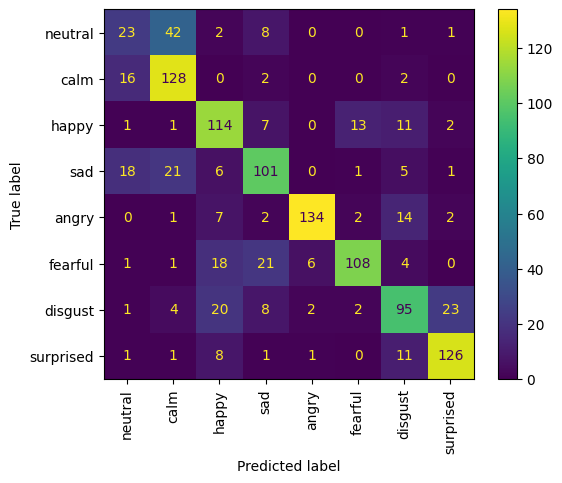

In [ ]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## CNN-biLSTM

In [ ]:
# Create a Sequential model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))

model.add(Dropout(0.3))
# Dense layer for classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 163, 32)           18464     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 79, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 39, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 39, 100)           46000     
 onal)                                                           
                                                      

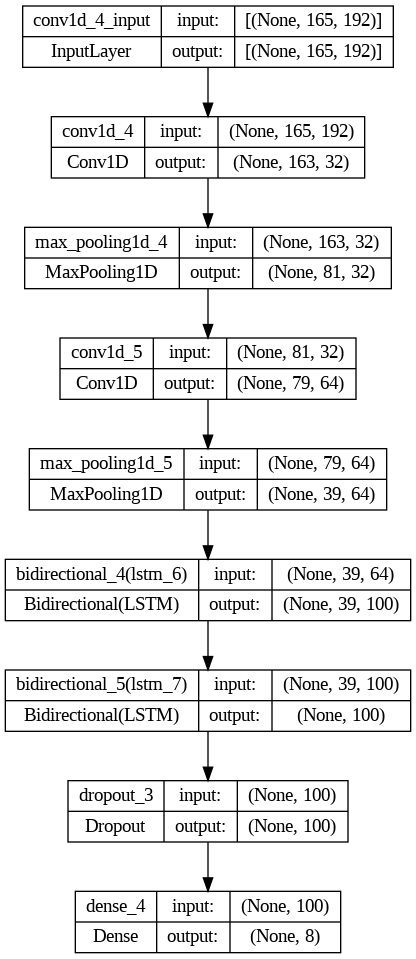

In [ ]:
plot_model(model, to_file="./CNN-biLSTM_model_arch.png", show_shapes=True)

In [ ]:
early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, min_delta=0.001, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./cnn_bilstm_model_checkpoint.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 14s 72ms/step - loss: 2.0334 - accuracy: 0.1944 - val_loss: 1.9203 - val_accuracy: 0.2597 - lr: 0.0010
Epoch 2/30
29/29 [==============================] - 1s 21ms/step - loss: 1.7875 - accuracy: 0.3073 - val_loss: 1.7746 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 3/30
29/29 [==============================] - 1s 21ms/step - loss: 1.6167 - accuracy: 0.3855 - val_loss: 1.6661 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 4/30
29/29 [==============================] - 1s 21ms/step - loss: 1.4615 - accuracy: 0.4582 - val_loss: 1.5502 - val_accuracy: 0.4199 - lr: 0.0010
Epoch 5/30
29/29 [==============================] - 1s 25ms/step - loss: 1.3332 - accuracy: 0.5060 - val_loss: 1.4211 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 6/30
29/29 [==============================] - 1s 26ms/step - loss: 1.2321 - accuracy: 0.5418 - val_loss: 1.5481 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 7/30
29/29 [==============================] - 1s 28ms/step - loss: 1.

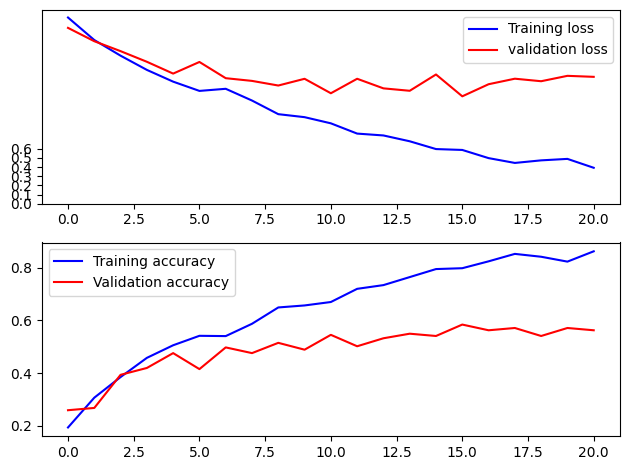

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

10/10 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.45      0.53      0.49        19
           1       0.73      0.80      0.76        44
           2       0.60      0.48      0.53        44
           3       0.62      0.51      0.56        39
           4       0.64      0.70      0.67        30
           5       0.60      0.64      0.62        33
           6       0.57      0.70      0.63        37
           7       0.82      0.72      0.77        43

    accuracy                           0.64       289
   macro avg       0.63      0.63      0.63       289
weighted avg       0.64      0.64      0.64       289



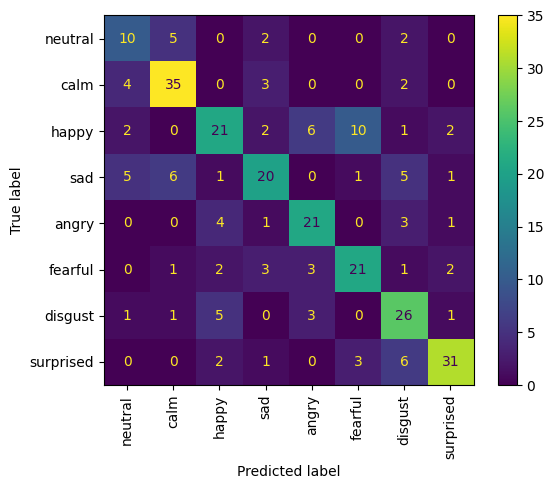

In [ ]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)

print(classification_report(true_labels, prediction_labels))
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

36/36 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        77
           1       0.73      0.89      0.80       148
           2       0.83      0.85      0.84       149
           3       0.80      0.58      0.67       153
           4       0.92      0.85      0.88       162
           5       0.90      0.86      0.88       159
           6       0.78      0.88      0.82       155
           7       0.89      0.88      0.89       149

    accuracy                           0.82      1152
   macro avg       0.81      0.81      0.80      1152
weighted avg       0.82      0.82      0.81      1152



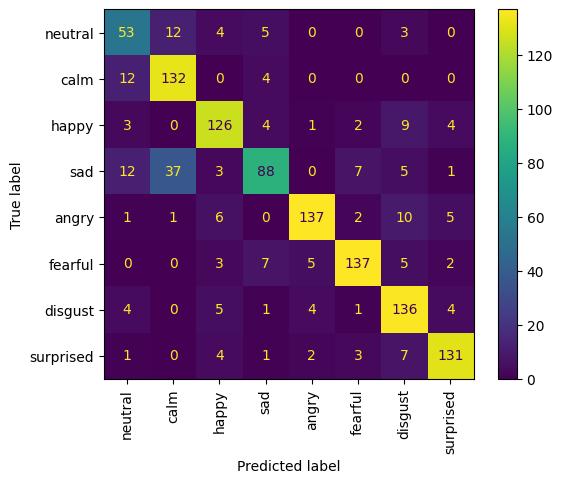

In [ ]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')